In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
exp_raw_data2 = '/content/drive/MyDrive/MODELLING/Dataset_modelB.xlsx'
collab_data = pd.read_excel(exp_raw_data2)

Mounted at /content/drive


In [ ]:
collab_data.corr().abs()['totalCr_concentration']

ID                       0.007451
trail_ID                 0.035084
colour_L                 0.276056
colour_a                 0.923980
colour_b                 0.960336
conductivity             0.121757
CrVI_concentration       0.955516
totalCr_concentration    1.000000
Name: totalCr_concentration, dtype: float64

In [ ]:
def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outliers_removed = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers_removed, outliers

columns_for_outlier_removal = ['totalCr_concentration','colour_a','colour_b','colour_L']

outliers_removed_data = collab_data.copy()
outliers_data = pd.DataFrame(columns=collab_data.columns)

for column in columns_for_outlier_removal:
    outliers_removed_data, outliers = remove_outliers_iqr(outliers_removed_data, column)
    outliers_data = pd.concat([outliers_data, outliers])

print('Outliers list length', len(outliers_data))
print('Corrected dataset length', len(outliers_removed_data))

Outliers list length 11
Corrected dataset length 202


In [ ]:
outliers_removed_data.corr().abs()['totalCr_concentration']

ID                       0.018164
trail_ID                 0.023491
colour_L                 0.252139
colour_a                 0.929097
colour_b                 0.959935
conductivity             0.113085
CrVI_concentration       0.954445
totalCr_concentration    1.000000
Name: totalCr_concentration, dtype: float64

In [ ]:
y = outliers_removed_data['totalCr_concentration']
features = ['colour_a','colour_b','colour_L','conductivity']
X = outliers_removed_data[features]

X_testing, X_train, y_testing, y_train = train_test_split(X, y, test_size=0.7, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_testing, y_testing, test_size=0.5, random_state=27)
print("Training set size", len(X_train))
print("Validation set size", len(X_val))
print("Training set size", len(X_test))
drive_path1 = '/content/drive/My Drive/MODELLING/X_testB_2.csv'
X_test.to_csv(drive_path1, index=False)
drive_path2 = '/content/drive/My Drive/MODELLING/y_testB_2.csv'
y_test.to_csv(drive_path2, index=False)

Training set size 142
Validation set size 30
Training set size 30


<Axes: ylabel='Frequency'>

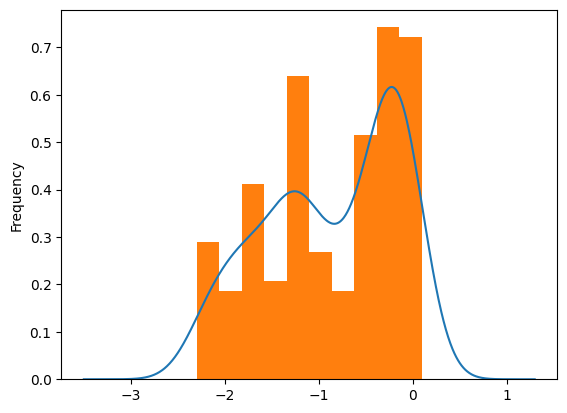

In [ ]:
outliers_removed_data['colour_a'].plot(kind='kde')
outliers_removed_data['colour_a'].plot(kind='hist', density = True)

<Axes: ylabel='Frequency'>

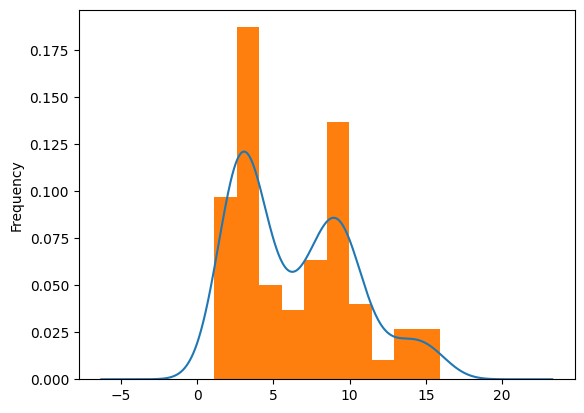

In [ ]:
outliers_removed_data['colour_b'].plot(kind='kde')
outliers_removed_data['colour_b'].plot(kind='hist', density = True)

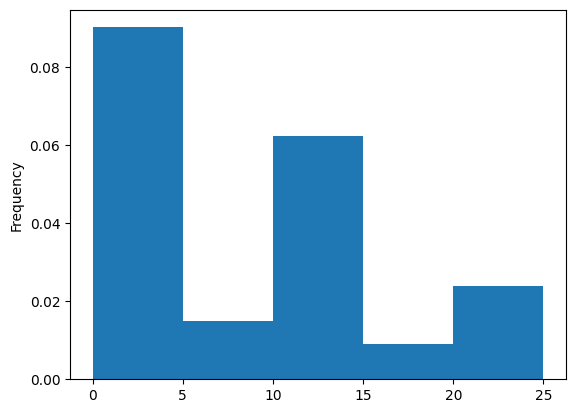

In [ ]:
hist = outliers_removed_data['totalCr_concentration'].plot(kind='hist', density = True, bins=5)

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)

majority_class_train = train_data[train_data['totalCr_concentration'] <= 12.5]
minority_class_train = train_data[train_data['totalCr_concentration'] > 12.5]

downsampled_majority_train = resample(majority_class_train,
                                      replace=False,
                                      n_samples=len(minority_class_train),
                                      random_state=27)

balanced_train_data = pd.concat([downsampled_majority_train, minority_class_train])

X_train_balanced = balanced_train_data[features]
y_train_balanced = balanced_train_data['totalCr_concentration']

print("Majority class size:", len(majority_class_train))
print("Minority class size:", len(minority_class_train))
print("Original training dataset size:", len(X_train))
print("Balanced training dataset size:", len(X_train_balanced))

Majority class size: 86
Minority class size: 56
Original training dataset size: 142
Balanced training dataset size: 112


rf_trail1_mae_TRAIN = 0.4707477546645908
rf_trail1_mape_TRAIN = 0.0780059134669774
rf_trail1_linearity_TRAIN = 0.9903677257632743


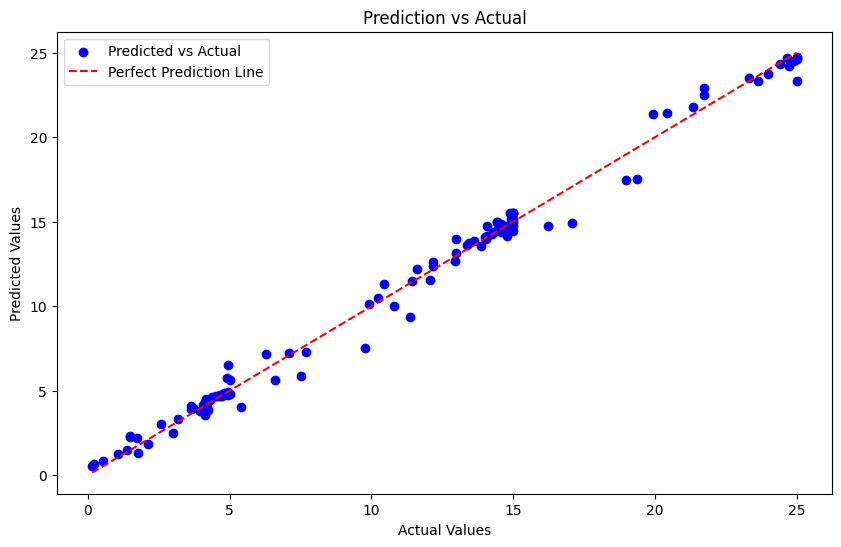

In [ ]:
rf_trail1 = RandomForestRegressor(random_state=27)
rf_trail1.fit(X_train_balanced, y_train_balanced)

rf_trail1_prediction_train = rf_trail1.predict (X_train_balanced)

rf_trail1_mae_TRAIN = mean_absolute_error(rf_trail1_prediction_train, y_train_balanced)
rf_trail1_mape_TRAIN = mean_absolute_percentage_error(rf_trail1_prediction_train, y_train_balanced)
rf_trail1_linearity_TRAIN = r2_score(rf_trail1_prediction_train, y_train_balanced)

print('rf_trail1_mae_TRAIN =', rf_trail1_mae_TRAIN)
print('rf_trail1_mape_TRAIN =', rf_trail1_mape_TRAIN)
print('rf_trail1_linearity_TRAIN =', rf_trail1_linearity_TRAIN)

plt.figure(figsize=(10, 6))
plt.scatter(y_train_balanced, rf_trail1_prediction_train, color='blue', label='Predicted vs Actual')
plt.plot([min(y_train_balanced), max(y_train_balanced)], [min(y_train_balanced), max(y_train_balanced)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

rf_trail1_mae = 1.1964168526673462
rf_trail1_mape = 0.145388202228121
rf_trail1_linearity = 0.9431557277218879


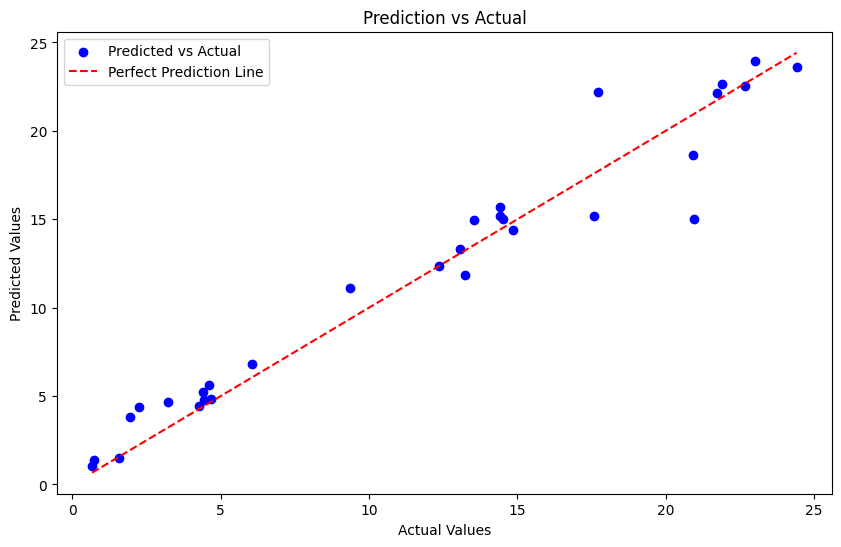

In [ ]:
rf_trail1_prediction = rf_trail1.predict (X_val)
rf_trail1_mae = mean_absolute_error(rf_trail1_prediction, y_val)
rf_trail1_mape = mean_absolute_percentage_error(rf_trail1_prediction, y_val)
rf_trail1_linearity = r2_score(rf_trail1_prediction, y_val)

print('rf_trail1_mae =', rf_trail1_mae)
print('rf_trail1_mape =', rf_trail1_mape)
print('rf_trail1_linearity =', rf_trail1_linearity)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_trail1_prediction, color='blue', label='Predicted vs Actual')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
feat_importance_model_rf_trail1 = pd.Series(rf_trail1.feature_importances_, index=X_train_balanced.columns)
feat_importance_model_rf_trail1.nlargest(5).plot(kind='barh')

Hyperparameter optimization (random grid search)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
max_depth = [int(x) for x in np.linspace (10, 110, num = 11)]
min_samples_leaf = [1,2,4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }

In [ ]:
def custom_score(y_true, y_pred):
    return r2_score(y_true, y_pred)
custom_scorer = make_scorer(custom_score)
rf_trail2 = RandomForestRegressor()
rf_trail2_random = RandomizedSearchCV(estimator=rf_trail2, param_distributions=random_grid,
                              n_iter = 100, scoring=custom_scorer,
                              cv = 5, verbose=2, random_state=35, n_jobs=-1,
                              return_train_score=True)

In [ ]:
rf_trail2_random.fit(X_train_balanced,y_train_balanced)
rf_trail2_prediction = rf_trail2_random.predict (X_train_balanced)

In [ ]:
params = rf_trail1.get_params()
print("Initial Parameters:")
for param_name, param_value in params.items():
    print(f"{param_name}: {param_value}")
print('Best Parameters found: ', rf_trail2_random.best_params_, ' \n' )

rf_trail2_mae_TRAIN = 0.47643931250903154
rf_trail2_mape_TRAIN = 0.07589674655641433
rf_trail2_linearity_TRAIN = 0.9902040167605145


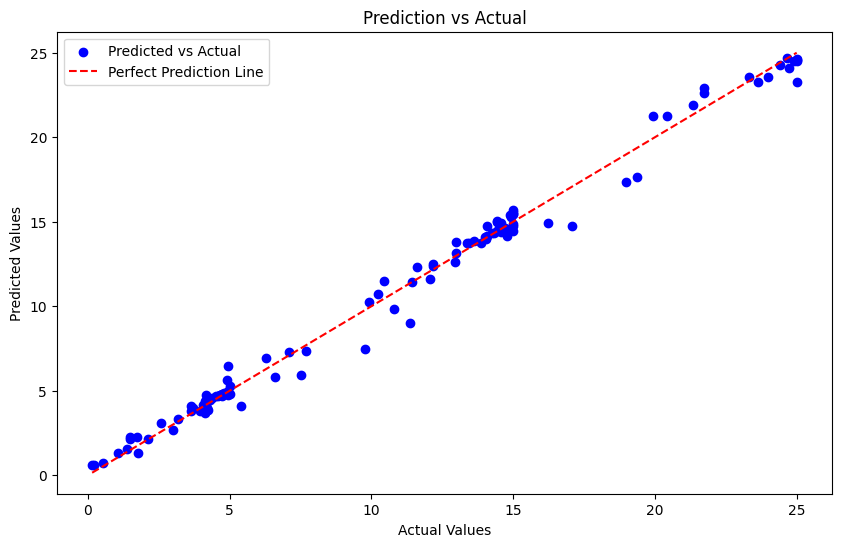

In [ ]:
rf_trail2_random_model = RandomForestRegressor(n_estimators = 120, min_samples_leaf = 1, max_features = 0.8, max_depth = 10, random_state = 27)
rf_trail2_prediction_train = rf_trail2_random_model.fit(X_train_balanced, y_train_balanced)
rf_trail2_prediction_train = rf_trail2_random_model.predict(X_train_balanced)

rf_trail2_mae_TRAIN = mean_absolute_error(rf_trail2_prediction_train, y_train_balanced)
rf_trail2_mape_TRAIN = mean_absolute_percentage_error(rf_trail2_prediction_train, y_train_balanced)
rf_trail2_linearity_TRAIN = r2_score(rf_trail2_prediction_train, y_train_balanced)

print('rf_trail2_mae_TRAIN =', rf_trail2_mae_TRAIN)
print('rf_trail2_mape_TRAIN =', rf_trail2_mape_TRAIN)
print('rf_trail2_linearity_TRAIN =', rf_trail2_linearity_TRAIN)

plt.figure(figsize=(10, 6))
plt.scatter(y_train_balanced, rf_trail2_prediction_train, color='blue', label='Predicted vs Actual')
plt.plot([min(y_train_balanced), max(y_train_balanced)], [min(y_train_balanced), max(y_train_balanced)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

rf_trail1_mae/rf_trail2_mae = 1.1964168526673462 1.1541200891098213
rf_trail1_mape/rf_trail2_mape = 0.145388202228121 0.14793611668213594
rf_trail1_linearity/rf_trail2_linearity = 0.9431557277218879 0.9451568141290022


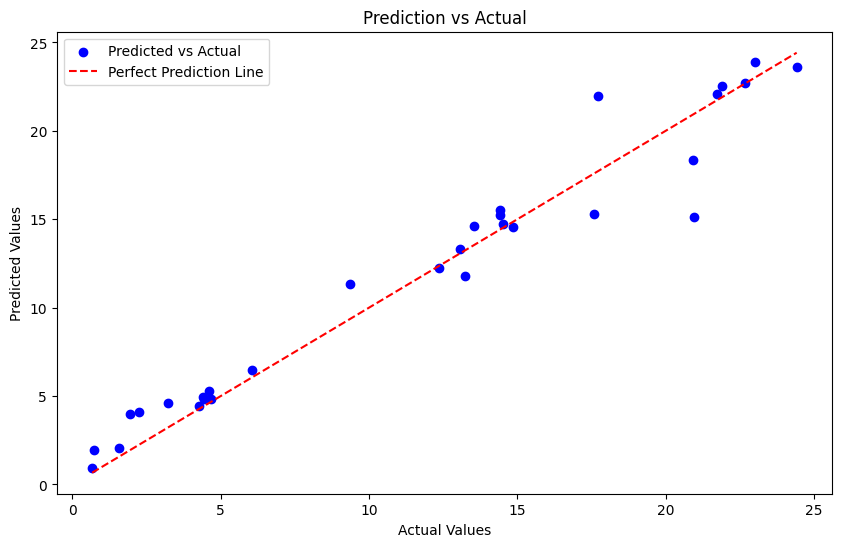

In [ ]:
rf_trail2_prediction = rf_trail2_random_model.predict (X_val)

rf_trail2_mae = mean_absolute_error(rf_trail2_prediction, y_val)
rf_trail2_mape = mean_absolute_percentage_error(rf_trail2_prediction, y_val)
rf_trail2_linearity = r2_score(rf_trail2_prediction, y_val)

print('rf_trail1_mae/rf_trail2_mae =', rf_trail1_mae, rf_trail2_mae)
print('rf_trail1_mape/rf_trail2_mape =', rf_trail1_mape, rf_trail2_mape)
print('rf_trail1_linearity/rf_trail2_linearity =', rf_trail1_linearity, rf_trail2_linearity)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_trail2_prediction, color='blue', label='Predicted vs Actual')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Hyperparameter optimization (bayesian optimization)

In [ ]:
!pip install bayesian-optimization scikit-learn pandas
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr

In [ ]:
def linearity_score(y_true, y_pred):
       residuals = y_true - y_pred
       corr_coef, _ = pearsonr(y_pred, residuals)
       return np.abs(corr_coef)

def objective(n_estimators, max_depth, min_samples_leaf, max_features):
    rf_trail3= RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_leaf=int(min_samples_leaf),
                                  max_features=min(max_features, 0.999),
                                  random_state=27)
    y_pred = cross_val_predict(rf_trail3, X_train_balanced, y_train_balanced, cv=5)
    mse = mean_squared_error(y_train_balanced, y_pred)
    linearity = linearity_score(y_train_balanced, y_pred)
    score = -mse - linearity
    return score

In [ ]:
param_bounds = {
    'n_estimators': (10, 1000),
    'max_depth': (1, 100),
    'min_samples_leaf': (1,5),
    'max_features': (0.1, 0.999),
}
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=27)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -3.55     | 43.15     | 0.8323    | 3.942     | 869.3     |
| 2         | -3.806    | 38.95     | 0.9805    | 4.573     | 217.6     |
| 3         | -4.177    | 74.44     | 0.6962    | 4.547     | 859.4     |
| 4         | -3.359    | 75.18     | 0.8823    | 1.747     | 332.3     |
| 5         | -3.412    | 37.92     | 0.8135    | 1.604     | 178.2     |
| 6         | -3.475    | 37.26     | 0.6526    | 1.302     | 179.2     |
| 7         | -3.817    | 43.31     | 0.999     | 4.123     | 170.4     |
| 8         | -3.664    | 80.92     | 0.2692    | 1.831     | 332.8     |
| 9         | -5.307    | 72.63     | 0.1022    | 3.214     | 335.5     |
| 10        | -3.359    | 74.75     | 0.5574    | 1.984     | 330.3     |
| 11        | -4.281    | 78.2      | 0.705     | 4.182     | 328.3     |
| 12        | -3.664    | 71.95     | 

In [ ]:
best_params=optimizer.max['params']
best_params

{'max_depth': 74.74516496181374,
 'max_features': 0.5574085735509149,
 'min_samples_leaf': 1.9837300728125014,
 'n_estimators': 330.30344415316614}

rf_trail3_mae_TRAIN = 0.45968004259454
rf_trail3_mape_TRAIN = 0.07625634010023834
rf_trail3_linearity_TRAIN = 0.9911728590389762


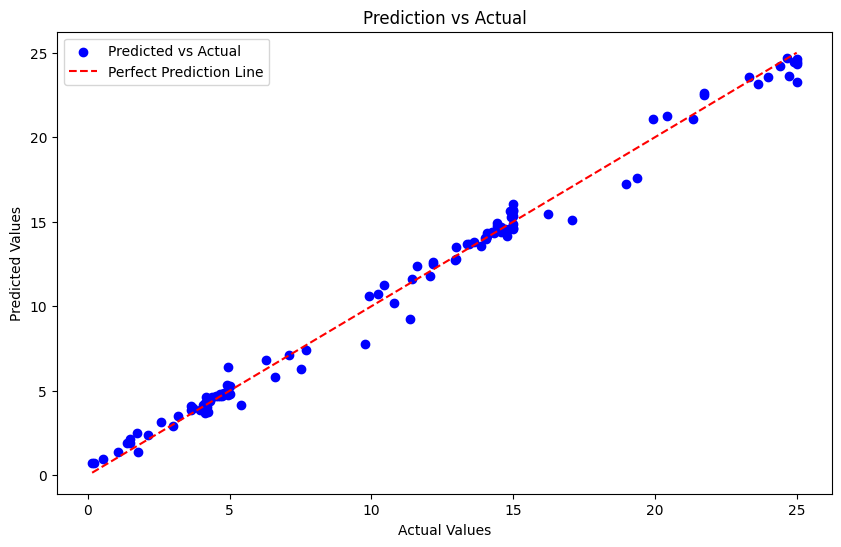

In [ ]:
rf_trail3_bayesian_model = RandomForestRegressor(n_estimators=int(best_params['n_estimators']),
                                   max_depth=int(best_params['max_depth']),
                                   min_samples_leaf=int(best_params['min_samples_leaf']),
                                   max_features=best_params['max_features'],
                                   random_state=27)
rf_trail3_prediction_train = rf_trail3_bayesian_model.fit(X_train_balanced, y_train_balanced)
rf_trail3_prediction_train = rf_trail3_bayesian_model.predict(X_train_balanced)

rf_trail3_mae_TRAIN = mean_absolute_error(rf_trail3_prediction_train, y_train_balanced)
rf_trail3_mape_TRAIN = mean_absolute_percentage_error(rf_trail3_prediction_train, y_train_balanced)
rf_trail3_linearity_TRAIN = r2_score(rf_trail3_prediction_train, y_train_balanced)

print('rf_trail3_mae_TRAIN =', rf_trail3_mae_TRAIN)
print('rf_trail3_mape_TRAIN =', rf_trail3_mape_TRAIN)
print('rf_trail3_linearity_TRAIN =', rf_trail3_linearity_TRAIN)

plt.figure(figsize=(10, 6))
plt.scatter(y_train_balanced, rf_trail3_prediction_train, color='blue', label='Predicted vs Actual')
plt.plot([min(y_train_balanced), max(y_train_balanced)], [min(y_train_balanced), max(y_train_balanced)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

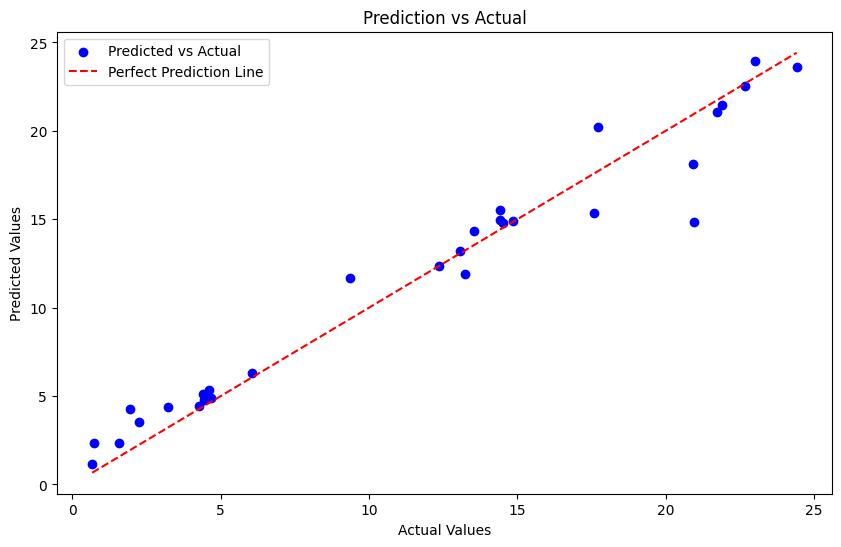

In [ ]:
rf_trail3_prediction = rf_trail3_bayesian_model.predict (X_val)

rf_trail3_mae = mean_absolute_error(rf_trail3_prediction, y_val)
rf_trail3_mape = mean_absolute_percentage_error(rf_trail3_prediction, y_val)
rf_trail3_linearity = r2_score(rf_trail3_prediction, y_val)

#print('rf_trail2_mae/rf_trail3_mae =', rf_trail2_mae, rf_trail3_mae)
#print('rf_trail2_mape/rf_trail3_mape =', rf_trail2_mape, rf_trail3_mape)
#print('rf_trail2_linearity/rf_trail3_linearity =', rf_trail2_linearity, rf_trail3_linearity)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_trail3_prediction, color='blue', label='Predicted vs Actual')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Final model saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from joblib import dump
rf_optimized_modelB_totalCr = rf_trail3_bayesian_model
drive_path = '/content/drive/My Drive/MODELLING/rf_optimized_modelB_totalCr.joblib'
dump(rf_optimized_modelB_totalCr, drive_path)
print("Model saved successfully to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to Google Drive.
